In [1]:
# Setup Working Directory
import os
import sys 
FolderList = [xx+"Dropbox\\Research Projects\\02_HeteFirm_AsymetricInformation\\Data\\Macro_data\\codes" \
              for xx in ["E:\\","B:\\","D:\\"]]
for Folder in FolderList:
    if os.path.exists(Folder):
        os.chdir(Folder)   
sys.path.append("../../../../../Code/PythonLib/")

In [2]:
#%% Import Moduels

## System Tools
import numpy as np
from collections import OrderedDict
import itertools
## I/O Tools
import pickle as pickle
## Data Process Tools
import pandas as pd
# import modin.pandas as pd
import datetime
## Graphs
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as figpdf
# import Graphics as MyGR
## Statistical Tools
import statsmodels.formula.api as sm
from statsmodels.tsa.api import VAR
from scipy.stats import mstats
from scipy.stats import t as TDist
import statsmodels.api as SMAPI
from statsmodels.tsa.tsatools import detrend as DeTrend
from statsmodels.tsa.filters.hp_filter import hpfilter as HPfilter
from statsmodels.tsa.filters.bk_filter import bkfilter as BKfilter
## Database API
from fredapi import Fred
fred = Fred(api_key='86cde3dec5dda5ffca44b58f01838b1e')
## Numerical API
from scipy.interpolate import interp1d
## Regular Expression API
import re

idx = pd.IndexSlice

import Toolkit_TimeSeries as MyTS
import Toolkit_Graphics as MyGR

## Stata
import stata_setup
stata_setup.config("D:/Stata17/","mp")
from pystata import stata
stata.run('set processors 8')
  

## Output Folder
OutputFolder = '../results/Calibration/'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
# End of Section: Setup Working Directory
###############################################################################



  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 8-core , expiring  1 Jan 2025
Serial number: 501709301094
  Licensed to: Xing Guo
               Bank of Canada

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.

Running c:\ado\plus\profile.do ...
command window is unrecognized
r(199);
    The maximum number of processors or cores being used 

# Collect the aggregate data

## Key shocks 

In [3]:
# TFP Shocks
AggTS_TFP = pd.read_excel('..\\datasets\\TFP\\TFP_Quarterly_2024Feb.xlsx').dropna().set_index("Date")
AggTS_TFP = AggTS_TFP/100.0
AggTS_TFP = AggTS_TFP[['dtfp','dtfp_util']] .rename(columns={'dtfp': 'dLog_TFP','dtfp_util': 'dLog_TFP_Adj'})
for vv in AggTS_TFP.columns:
    Temp = SMAPI.tsa.x13_arima_analysis(AggTS_TFP[vv],log=False)
    AggTS_TFP[vv] = Temp.seasadj
    
# Monetary Policy Shocks
## Romer & Romer Shock
AggTS_MS_RR = pd.read_stata('..\\datasets\\MonetaryShock\\RR_monetary_shock_quarterly.dta')
AggTS_MS_RR = AggTS_MS_RR.set_index('date')['resid_full'].rename('MS_RR')

## High-frequency shocks 
AggTS_MS_Pablo = pd.read_excel('..\\datasets\\MonetaryShock\\MonetaryShock_HF_OttonelloWinberry.xlsx')
AggTS_MS_Pablo['QDate'] = AggTS_MS_Pablo['dateq'].map(lambda x: datetime.datetime(int(x[0:4]),3*(int(x[-1])-1)+1,1))
AggTS_MS_Pablo = AggTS_MS_Pablo.rename(columns={'Main shock (sum)': 'MS_HF_OW_sum', 'Main shock (smoothed)': 'MS_HF_OW_smoothed'}) \
                .set_index('QDate').drop('dateq', axis=1)*100

## Effective Fed Funds Rates
AggTS_Rate_M = pd.read_excel('..\\datasets\\MonetaryShock\\InterestRate_M.xlsx')
# Convert the Monthly Date to Quarterly Date
AggTS_Rate_M['QDate'] = AggTS_Rate_M['Date'].map(lambda x: datetime.datetime(x.year, (x.quarter-1)*3+1 ,1 ))
AggTS_Rate_Q = AggTS_Rate_M.groupby('QDate')[['FFR_EffectiveRate', 'WuXia_EffectiveRate']].mean()

In [4]:
GZ_FinShock_M = pd.read_csv('../datasets/FinancialShocks/GZ_M_August_2016.csv')

def MDate2QDate(MDate):
    yymm = [int(xx) for xx in MDate.split('m')]
    yy = yymm[0]
    mm = yymm[1]

    return datetime.datetime(yy,int(np.floor((mm-1)/3)*3+1),1)

GZ_FinShock_M['QDate'] = GZ_FinShock_M['date'].map(MDate2QDate)
GZ_FinShock_Q = GZ_FinShock_M.groupby('QDate')['ebp_oa'].mean().rename('EBP')

In [5]:
# Aggregate Shocks
AggDS_Shocks = pd.concat([AggTS_TFP, AggTS_MS_RR, AggTS_MS_Pablo, AggTS_Rate_Q, GZ_FinShock_Q], axis=1).sort_index()

pickle.dump(AggDS_Shocks, open("../temp/AggDS_Shocks.p", 'wb'))


## Key NIPA items

In [6]:
# Data from FRED
class FredTS:
    def __init__(self,FredCode,Label,SA=True,LogLin='Lin',Diff=False):
        self.Code = FredCode
        self.Label = Label
        self.SA = SA            # whether needs seasonal adjustment
        self.LogLin = LogLin    # Log or Lin deviation around the steady state
        self.Diff = Diff        # whether needs to take difference

# Download Data from FRED
VarInfo = {'PCE': FredTS('PCECC96','Real Private Consumption',LogLin='Log',Diff=True), \
           'PDI': FredTS('GPDIC1','Real Gross Private Domestic Investment', LogLin='Log', Diff=True), \
           'PDI_NonRes': FredTS('PNFI','Nominal Gross Private Domestic Investment (Non-residential)', LogLin='Log', Diff=True), \
           'BFI': FredTS('PNFIC1','Real Private Nonresidential Fixed Investment', LogLin='Log', Diff=True), \
           'GCE': FredTS('GCEC1','Real Government Expenditure and Investment', LogLin='Log', Diff=True), \
           'GDP': FredTS('GDPC1', 'Real GDP', LogLin='Log', Diff=True), \
           'GdpPerCap': FredTS('A939RX0Q048SBEA', 'Real GDP per Capita', LogLin='Log', Diff=True), \
           'PcePerCap': FredTS('A794RX0Q048SBEA', 'Real PCE per Capita', LogLin='Log', Diff=True), \
           'Hours': FredTS('HOHWMN02USQ065S', 'Hours', LogLin='Log', Diff=True), \
           'Wage': FredTS('USAHOUREAQISMEI','Nominal wage', LogLin='Log', Diff=True), \
           'Earning': FredTS('LES1252881600Q', 'Real weekly earning', LogLin='Log', Diff=True), \
           'GdpDef': FredTS('USAGDPDEFQISMEI','GDP Deflator',LogLin='Log', Diff=True), \
           'InvPrice': FredTS('INVDEF','Relative Price of Investment Goods',LogLin='Log', Diff=True), \
           'FedFundRate': FredTS('FEDFUNDS', 'Effective Federal Funds Rates'), \
           'LongTermRate': FredTS('GS10','10-Year Treasury Yield'), \
           'UnemploymentRate': FredTS('UNRATE','Unemployment Rate'), \
           'CPI_Inflation': FredTS('CPALTT01USQ657N','CPI inflation rate') }
Data_Fred = {}
for vv in VarInfo.keys():
    print('Download data for ',VarInfo[vv].Label)
    Data_Fred[vv] = fred.get_series(VarInfo[vv].Code).rename(vv)


Download data for  Real Private Consumption
Download data for  Real Gross Private Domestic Investment
Download data for  Nominal Gross Private Domestic Investment (Non-residential)
Download data for  Real Private Nonresidential Fixed Investment
Download data for  Real Government Expenditure and Investment
Download data for  Real GDP
Download data for  Real GDP per Capita
Download data for  Real PCE per Capita
Download data for  Hours
Download data for  Nominal wage
Download data for  Real weekly earning
Download data for  GDP Deflator
Download data for  Relative Price of Investment Goods
Download data for  Effective Federal Funds Rates
Download data for  10-Year Treasury Yield
Download data for  Unemployment Rate
Download data for  CPI inflation rate


In [7]:

# Clean the Data from NIPA
TS_Dict = {}
Sample_Period = (datetime.datetime(1965,1,1), datetime.datetime(2023,1,1))

## Ten-year Treasury Yield
Temp = Data_Fred['LongTermRate'].to_frame().reset_index().rename(columns={'index': 'MDate'})
Temp['QDate'] = Temp['MDate'].map(lambda x: datetime.date(x.year,3*int(np.floor((x.month-1)/3))+1,1))

TS_Dict['NomRate_LT'] = Temp.groupby('QDate')['LongTermRate'].mean()
## Effective Federal Funds Rate
Temp = Data_Fred['FedFundRate'].to_frame().reset_index().rename(columns={'index': 'MDate'})
Temp['QDate'] = Temp['MDate'].map(lambda x: datetime.date(x.year,3*int(np.floor((x.month-1)/3))+1,1))

TS_Dict['NomRate_ST'] = Temp.groupby('QDate')['FedFundRate'].mean()

## Unemployment
Temp = Data_Fred['UnemploymentRate'].to_frame().reset_index().rename(columns={'index': 'MDate'})
Temp['QDate'] = Temp['MDate'].map(lambda x: datetime.date(x.year,3*int(np.floor((x.month-1)/3))+1,1))
TS_Dict['UnEmpRate'] = Temp.groupby('QDate')['UnemploymentRate'].mean()

## Others
for vv in ['PCE', 'PDI',  'PDI_NonRes', 'BFI', 'GCE', 'GDP', 'GdpPerCap', 'PcePerCap', 'Hours', 'GdpDef', 'InvPrice', 'Wage', 'Earning', 'CPI_Inflation']:
    TS_Dict[vv] = Data_Fred[vv].copy()
    TS_Dict[vv].index = TS_Dict[vv].index.map(lambda x: x.date())

DS_Original = pd.concat(TS_Dict, axis=1).sort_index()
DS_Original['RealInvPrice'] = DS_Original['InvPrice']/DS_Original['GdpDef']
DS_Original['RealWage'] = DS_Original['Wage']/DS_Original['GdpDef']
DS_Original['CPI'] = DS_Original['CPI_Inflation'].cumsum()
DS_Original['PDI_NonRes'] = DS_Original['PDI_NonRes']/DS_Original['GdpDef']

# Tranform the data
DS_ToBeFiltered = DS_Original.copy()
DS_ToBeFiltered.index = pd.to_datetime(DS_ToBeFiltered.index)

## Take Logs 
for vv in ['PCE', 'PDI', 'PDI_NonRes', 'BFI', 'GCE', 'GDP', 'GdpPerCap', 'PcePerCap', 'Hours', 'GdpDef', 'InvPrice', 'RealInvPrice', 'Wage', 'RealWage', 'Earning']:
    DS_ToBeFiltered[vv] = np.log(DS_ToBeFiltered[vv])*100
    DS_ToBeFiltered['Growth_'+vv] = DS_ToBeFiltered[vv].diff(1)
    if vv in ['GdpDef', 'InvPrice', 'RealInvPrice', 'Wage', 'RealWage', 'Earning']:
        DS_ToBeFiltered['Growth_'+vv] = DS_ToBeFiltered['Growth_'+vv] * 4

DS_ToBeFiltered = DS_ToBeFiltered.loc[(DS_ToBeFiltered.index>=Sample_Period[0]) & \
                                      (DS_ToBeFiltered.index<=Sample_Period[1]), :].sort_index()
## Filter the Data
AggDS_Dict = MyTS.FilterTimeSeries(DS_ToBeFiltered)
AggDS_Dict['Original'] = DS_Original



In [8]:
pickle.dump(AggDS_Dict, open("../temp/AggDS_Dict_AggPQ.p", 'wb'))

# Empirical Evidence

## Construct the Sample

In [9]:
AggTS_AggPQ = pickle.load(open('../temp/AggDS_Dict_AggPQ.p','rb'))['Level']
AggTS_Shocks = pickle.load(open('../temp/AggDS_Shocks.p','rb'))

In [10]:
AggTS = pd.concat([AggTS_AggPQ, AggTS_Shocks], axis=1).sort_index()

In [11]:
DS = pd.concat([AggTS,], axis=1).sort_index()

In [12]:
Sample_Period = (datetime.datetime(1969,1,1), datetime.datetime(2008,1,1))

DS = DS.loc[(DS.index>=Sample_Period[0]) & (DS.index<=Sample_Period[1]), :]

In [13]:
DS['Log_TFP_Adj'] = DS['dLog_TFP_Adj'].cumsum()/4

In [14]:
DS.columns

Index(['NomRate_LT', 'NomRate_ST', 'UnEmpRate', 'PCE', 'PDI', 'PDI_NonRes',
       'BFI', 'GCE', 'GDP', 'GdpPerCap', 'PcePerCap', 'Hours', 'GdpDef',
       'InvPrice', 'Wage', 'Earning', 'CPI_Inflation', 'RealInvPrice',
       'RealWage', 'CPI', 'Growth_PCE', 'Growth_PDI', 'Growth_PDI_NonRes',
       'Growth_BFI', 'Growth_GCE', 'Growth_GDP', 'Growth_GdpPerCap',
       'Growth_PcePerCap', 'Growth_Hours', 'Growth_GdpDef', 'Growth_InvPrice',
       'Growth_RealInvPrice', 'Growth_Wage', 'Growth_RealWage',
       'Growth_Earning', 'dLog_TFP', 'dLog_TFP_Adj', 'MS_RR', 'MS_HF_OW_sum',
       'MS_HF_OW_smoothed', 'FFR_EffectiveRate', 'WuXia_EffectiveRate', 'EBP',
       'Log_TFP_Adj'],
      dtype='object')

## Regression setup (local projection)

In [15]:
YVarList = ['PDI', 'PDI_NonRes', 'dLog_TFP_Adj', 'Log_TFP_Adj', 'GDP', 'GdpDef', 'CPI', 'UnEmpRate', 'NomRate_ST', 'InvPrice']
ShockList = ['MS_RR',]
ControlVarList = ['NomRate_ST', 'GDP', 'CPI', 'UnEmpRate', 'EBP']
N_MaxLead = 16
N_MaxLag = 4 

In [16]:
RegDS = DS.loc[:, list(set(YVarList+ShockList+ControlVarList))].copy()

In [17]:
def UnitFun_GenLagVariable(DS, vv, N, LagLeadFlag='Lag'):
    TempVarList = []
    for nn in range(N+1):
        TempVar = ''.join([vv, '_Lag_' if LagLeadFlag=='Lag' else '_Lead_', str(nn)])
        DS[TempVar] = DS[vv].shift(nn if LagLeadFlag=='Lag' else -nn)
        TempVarList.append(TempVar)
    return TempVarList 
    
# Lag of outcome variable 
for vv in YVarList:
    UnitFun_GenLagVariable(RegDS, vv, N_MaxLag, 'Lag')
    UnitFun_GenLagVariable(RegDS, vv, N_MaxLead, 'Lead')
# Lag of shock 
for vv in ShockList:
    UnitFun_GenLagVariable(RegDS, vv, N_MaxLag, 'Lag')
# Lag of control variables
for vv in ControlVarList:
    UnitFun_GenLagVariable(RegDS, vv, N_MaxLag, 'Lag')


C:\Users\guoxi\AppData\Local\Temp\ipykernel_22996\3390471686.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DS[TempVar] = DS[vv].shift(nn if LagLeadFlag=='Lag' else -nn)
C:\Users\guoxi\AppData\Local\Temp\ipykernel_22996\3390471686.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DS[TempVar] = DS[vv].shift(nn if LagLeadFlag=='Lag' else -nn)
C:\Users\guoxi\AppData\Local\Temp\ipykernel_22996\3390471686.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

In [18]:
def UnitReg(YVar, XVarList, AbsorbVarList, ClusterVarList, SampleRestriction, WeightVar='', RegCommand='reghdfe', Level=95, PrintFlag=False):
    # Compose the Stata Command
    OptionList = []
    OptionList.append('noabsorb') if len(AbsorbVarList)==0 else OptionList.append('absorb('+' '.join(AbsorbVarList)+')')
    if RegCommand=='ivreghdfe':
        if len(ClusterVarList)>0:
            OptionList.append('cluster('+' '.join(ClusterVarList)+')')
    elif RegCommand=='reghdfe':
        if len(ClusterVarList)>0:
            OptionList.append('vce(cluster'+' '.join(ClusterVarList)+')')

    OptionList.append('level('+str(Level)+')')
    # Run regression
    if PrintFlag:
        print('Start running regression for',YVar,':')
    StataCommand = ' '.join([RegCommand,YVar]+XVarList+[SampleRestriction])+('' if len(WeightVar)==0 else ' [weight='+WeightVar+']')+', '+' '.join(OptionList)
    stata.run(StataCommand, quietly=True)
    # Collect the results
    RegResults = stata.get_ereturn()
    if RegCommand=='ivreghdfe':
        VarList = RegResults['e(instd)'].split(' ') + RegResults['e(inexog)'].split(' ')
    else:
        VarList = RegResults['e(indepvars)'].split(' ')

    Coef = RegResults['e(b)'][0]
    SE = np.sqrt(RegResults['e(V)'].diagonal())
    DoF = RegResults['e(df_r)']

    TValue = Coef/SE
    PValue = TDist.cdf(-np.abs(TValue),df=DoF)+TDist.sf(np.abs(TValue),df=DoF)

    TDistQuant = TDist.ppf(q=[(1-Level/100)/2,1-(1-Level/100)/2],df=DoF)
    CI_Left = Coef + TDistQuant[0]*SE
    CI_Right = Coef + TDistQuant[1]*SE

    Ind = np.abs(SE)>0
    templist = []
    for (ii, vv) in enumerate(Ind):
        if vv:
            templist.append(VarList[ii])
    RegTable = pd.concat([pd.Series(xx,index=templist) for xx in [Coef[Ind],SE[Ind],TValue[Ind],PValue[Ind],CI_Left[Ind],CI_Right[Ind]]],axis=1,keys=['Coef', 'SE', 'TValue', 'PValue', 'CI_Left', 'CI_Right'])
    
    if PrintFlag:
        print('Done.')
    return RegTable

In [19]:
def LocalProj(YVar, XVar, Sample_Period = (datetime.datetime(1985,1,1), datetime.datetime(2008,1,1))):

    YVarList_Full = [''.join([YVar, '_Lead_', str(nn)]) for nn in range(N_MaxLead+1)]
    ControlList_Full = [''.join([YVar, '_Lag_', str(nn)]) for nn in range(1, N_MaxLag+1)] + \
                    [''.join([XVar, '_Lag_', str(nn)]) for nn in range(1, N_MaxLag+1)] 
    for vv in ControlVarList:
        if vv!=YVar:
            ControlList_Full = ControlList_Full + [''.join([vv, '_Lag_', str(nn)]) for nn in range(1, N_MaxLag+1)] 
    ControlList_Full = list(set(ControlList_Full))
    
    TempInd = (RegDS.index>=Sample_Period[0]) & (RegDS.index <=Sample_Period[1])
    DS_Stata = RegDS.loc[TempInd, [XVar, ] + YVarList_Full + ControlList_Full].reset_index().rename(columns={'index': 'QDate'}).dropna()
    for tt in range(N_MaxLead+1):
        DS_Stata[YVar+'_LeadDiff_'+str(tt)] = DS_Stata[YVar+'_Lead_'+str(tt)] - DS_Stata[YVar+'_Lag_'+str(1)]
    stata.pdataframe_to_data(DS_Stata,force=True)
    
    RegResult = pd.concat([UnitReg(YVar+'_LeadDiff_'+str(tt), [XVar]+ ControlList_Full, [], [], '', WeightVar='', RegCommand='reghdfe', Level=95).loc[XVar, :] \
                           for tt in range(N_MaxLead+1)], axis=1, keys=range(N_MaxLead+1)).T
    
    return RegResult

In [20]:
RegDS['PDI_NonRes']

1969-01-01    179.040573
1969-04-01    180.043204
1969-07-01    182.071424
1969-10-01    181.506644
1970-01-01    180.249047
                 ...    
2007-01-01    307.308685
2007-04-01    308.627216
2007-07-01    309.232767
2007-10-01    310.383132
2008-01-01    311.611540
Freq: QS-OCT, Name: PDI_NonRes, Length: 157, dtype: float64

## Running the regression

In [21]:
RegDict = {}
for xx in ShockList:
    RegDict[xx] = {}
    for yy in YVarList:
        if xx!=yy:
            print("Running the local projection of ", yy, " on ", xx, ":")
            RegDict[xx][yy] = LocalProj(yy, xx, Sample_Period = (datetime.datetime(1969,1,1), datetime.datetime(2008,1,1)))

Running the local projection of  PDI  on  MS_RR :


Running the local projection of  PDI_NonRes  on  MS_RR :
Running the local projection of  dLog_TFP_Adj  on  MS_RR :
Running the local projection of  Log_TFP_Adj  on  MS_RR :
Running the local projection of  GDP  on  MS_RR :
Running the local projection of  GdpDef  on  MS_RR :
Running the local projection of  CPI  on  MS_RR :
Running the local projection of  UnEmpRate  on  MS_RR :
Running the local projection of  NomRate_ST  on  MS_RR :
Running the local projection of  InvPrice  on  MS_RR :


## Present the IRF 

In [22]:
IRF_Info_SE = MyGR.IRF('Coef',ErrorBand_Flag='Std',ErrorBand_Param=['SE',1],Line=MyGR.Line(Color=MyGR.MyColor('Red'),Style='dashed'),Area_Info=MyGR.Area(Color='Red', Alpha=0.1))
IRF_Info_CI = MyGR.IRF('Coef',ErrorBand_Flag='CI',ErrorBand_Param=['CI_Left','CI_Right'],Line=MyGR.Line(Color=MyGR.MyColor('Blue'),Style='solid'),Area_Info=MyGR.Area(Color='Blue',Alpha=0.1))

In [23]:
TitleDict = {'PDI': 'Investment', 'PDI_NonRes': 'Non-residential investment', 'dLog_TFP_Adj': 'TFP growth', 'GDP': 'GDP', \
             'PCE': 'Consumption', 'CPI': 'Price level', 'InvPrice': 'Investment goods price', \
             'NomRate_ST': 'Fed funds rate', 'Log_TFP_Adj': 'TFP', \
             'UnEmpRate': 'Unemployment rate'}


In [24]:
def UnitVarIRF(VarList, IrfDS, ShVar, N_Row=3, N_Col=3, scale=1):

    Fig = MyGR.Setup_Fig(FigSize=(1/3*N_Col,1/4*N_Row))
    for ii, vv in enumerate(VarList):
        ax = Fig.add_subplot(N_Row,N_Col,ii+1)
        temp = IrfDS[ShVar][vv].copy()
        for cc in ['Coef', 'SE', 'CI_Left', 'CI_Right']:
            temp[cc] = temp[cc]*scale
        ax = MyGR.Plot_IRF(temp,IRF_Info_CI,Symmetry=True)
        plt.title(TitleDict[vv], fontsize=8)

        plt.tight_layout()
    return 

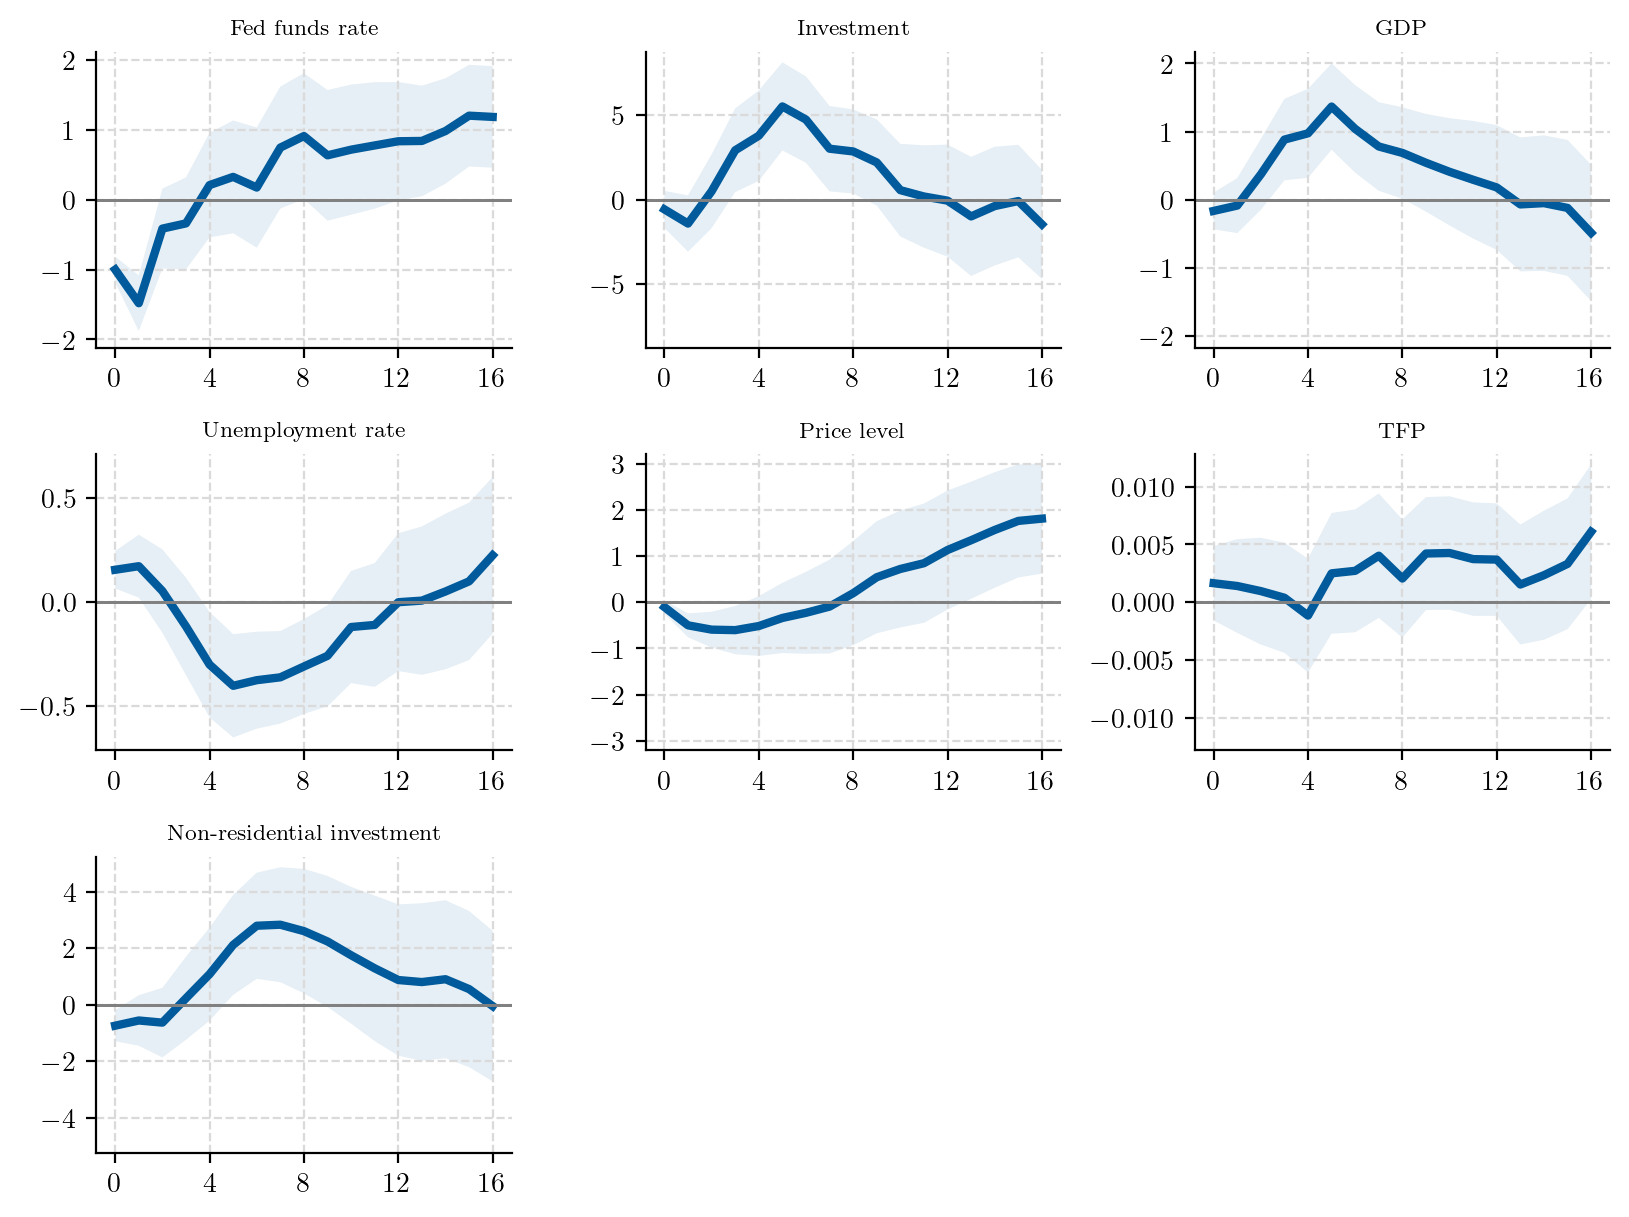

In [25]:
TempList = ['NomRate_ST', 'PDI', 'GDP', 'UnEmpRate',  'CPI', 'Log_TFP_Adj', 'PDI_NonRes']
UnitVarIRF(TempList, RegDict, 'MS_RR', scale=-1/RegDict['MS_RR']['NomRate_ST'].loc[0, 'Coef'])


In [26]:
IRF_Info_Agg = MyGR.IRF('Coef',ErrorBand_Flag='CI',ErrorBand_Param=['CI_Left','CI_Right'],Line=MyGR.Line(Color=MyGR.MyColor('Black'),Style='solid'),Area_Flag=True,Area_Info=MyGR.Area(Color='Black',Alpha=0.1))

def UnitFun_IRF(IrfDS, ShVar, vv, scale=1):

    Fig = MyGR.Setup_Fig(FigSize=(1/3, 1/4))
    ax = Fig.add_subplot(1, 1, 1)
    temp = IrfDS[ShVar][vv].copy()
    for cc in ['Coef', 'SE', 'CI_Left', 'CI_Right']:
        temp[cc] = temp[cc]*scale
    ax = MyGR.Plot_IRF(temp,IRF_Info_Agg,Symmetry=True)
    ax.set_xlabel("Quarter", fontsize=8)
    ax.set_ylabel("Percent", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    plt.tight_layout()
    
    return Fig, ax

In [27]:
pwd()

'D:\\Dropbox\\Research Projects\\02_HeteFirm_AsymetricInformation\\Data\\Macro_data\\codes'

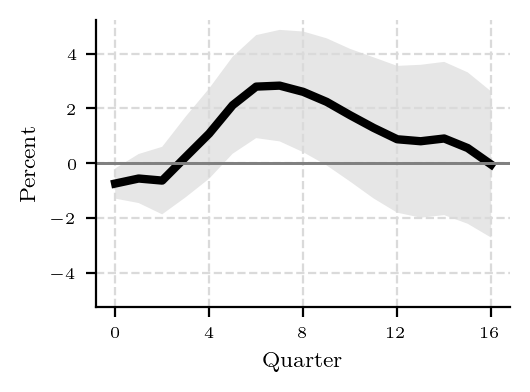

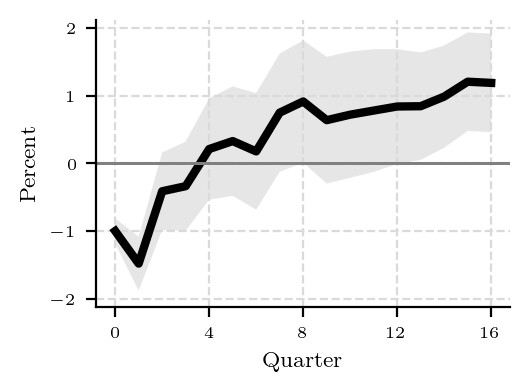

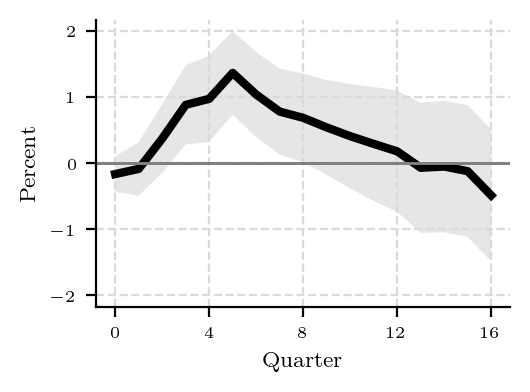

In [34]:
UnitFun_IRF(RegDict, 'MS_RR', 'PDI_NonRes', scale=-1/RegDict['MS_RR']['NomRate_ST'].loc[0, 'Coef'])
plt.savefig(OutputFolder + "/IRF_M_Inv.eps")

UnitFun_IRF(RegDict, 'MS_RR', 'NomRate_ST', scale=-1/RegDict['MS_RR']['NomRate_ST'].loc[0, 'Coef'])
plt.savefig(OutputFolder + "/IRF_M_R.eps")

UnitFun_IRF(RegDict, 'MS_RR', 'GDP', scale=-1/RegDict['MS_RR']['NomRate_ST'].loc[0, 'Coef'])
plt.savefig(OutputFolder + "/IRF_M_Y.eps")

In [29]:
IRF_MS = pd.concat(RegDict['MS_RR'], axis=1).swaplevel(i=0, j=1, axis=1).sort_index(axis=1)['Coef']

In [30]:
IRF_MS = -IRF_MS/IRF_MS.loc[0, 'NomRate_ST']

In [31]:
IRF_MS

,CPI,GDP,GdpDef,InvPrice,Log_TFP_Adj,NomRate_ST,PDI,PDI_NonRes,UnEmpRate,dLog_TFP_Adj
0,-0.105050,-0.163965,-0.057280,-0.129805,0.001644,-1.000000,-0.570000,-0.741222,0.155949,0.005202
1,-0.500080,-0.085686,-0.197132,-0.369322,0.001405,-1.481316,-1.407694,-0.557570,0.173283,-0.001271
2,-0.593398,0.372442,-0.301313,-0.646555,0.000962,-0.413225,0.500829,-0.633177,0.053921,-0.001825
3,-0.604115,0.883152,-0.335488,-0.807608,0.000390,-0.338490,2.923147,0.229615,-0.116036,-0.003851
4,-0.515134,0.974751,-0.393729,-0.910958,-0.001152,0.210012,3.784831,1.083998,-0.299672,-0.002690
5,-0.340001,1.367626,-0.396772,-0.920941,0.002499,0.327206,5.514658,2.119800,-0.401503,0.010410
6,-0.229065,1.039810,-0.388495,-0.869746,0.002716,0.174761,4.735925,2.798404,-0.374464,-0.000968
7,-0.094090,0.781548,-0.288539,-0.813847,0.004024,0.746823,3.015740,2.834242,-0.360694,0.005327
8,0.195950,0.687328,-0.127913,-0.695295,0.002052,0.911989,2.853799,2.607550,-0.308680,-0.006286
9,0.542159,0.542467,0.074468,-0.607762,0.004213,0.635932,2.204051,2.241646,-0.257328,0.006656


In [32]:
RegDS['dLog_TFP_Adj'].autocorr(lag=1)*2 + 1

0.7687812956997757

In [33]:
RegDS['dLog_TFP_Adj'].autocorr(lag=1)

-0.11560935215011213

# VAR Evidence

## Setup